# 다중 에이전트 백테스팅 시스템

5개 투자 에이전트(Graham, Buffett, Greenblatt, Piotroski, Altman)의 성과를 종합적으로 백테스팅하고 비교분석합니다.


In [14]:
# 다중 에이전트 백테스팅 시스템
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

import yfinance as yf

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

class MultiAgentBacktester:
    """5개 투자 에이전트 통합 백테스팅 클래스"""
    
    def __init__(self, 
                 results_dir="results",
                 ohlcv_path="data/nasdaq100_ohlcv.csv",
                 benchmark_cache_path="data/benchmark_data.csv",
                 transaction_cost=0.0001):  # 0.01% 거래비용
        
        self.results_dir = results_dir
        self.ohlcv_path = ohlcv_path
        self.benchmark_cache_path = benchmark_cache_path
        self.transaction_cost = transaction_cost
        
        # 에이전트 정보 정의
        self.agents = {
            'graham': {
                'name': 'Benjamin Graham',
                'directory': 'graham_agent',
                'portfolio_prefix': 'graham_portfolio_',
                'color': 'blue'
            },
            'buffett': {
                'name': 'Warren Buffett',
                'directory': 'buffett_agent',
                'portfolio_prefix': 'buffett_portfolio_',
                'color': 'red'
            },
            'greenblatt': {
                'name': 'Joel Greenblatt',
                'directory': 'greenblatt_agent',
                'portfolio_prefix': 'greenblatt_portfolio_',
                'color': 'green'
            },
            'piotroski': {
                'name': 'Joseph Piotroski',
                'directory': 'piotroski_agent',
                'portfolio_prefix': 'piotroski_portfolio_',
                'color': 'orange'
            },
            'altman': {
                'name': 'Edward Altman',
                'directory': 'altman_agent',
                'portfolio_prefix': 'altman_portfolio_',
                'color': 'purple'
            }
        }
        
        # 벤치마크 티커들 정의
        self.benchmarks = {
            'QQQ': {'name': 'NASDAQ 100 ETF', 'color': 'black'},
            'SPY': {'name': 'S&P 500 ETF', 'color': 'gray'}
        }
        
        # 데이터 로드
        self.load_data()
        
        # 백테스팅 결과 저장용
        self.backtest_results = {}
        
    def download_and_cache_benchmark_data(self, start_date='2020-01-01', end_date=None):
        """Yahoo Finance에서 벤치마크 데이터를 다운로드하고 캐시에 저장"""
        
        if end_date is None:
            end_date = datetime.now().strftime('%Y-%m-%d')
            
        print("벤치마크 데이터 다운로드 및 캐싱 중...")
        
        all_benchmark_data = []
        
        for ticker in self.benchmarks.keys():
            try:
                print(f"  - {ticker} ({self.benchmarks[ticker]['name']}) 다운로드 중...")
                
                data = yf.download(ticker, start=start_date, end=end_date, progress=False)
                
                if data.empty:
                    print(f"    경고: {ticker} 데이터를 가져올 수 없습니다.")
                    continue
                    
                data = data.reset_index()
                data['ticker'] = ticker
                data['date'] = pd.to_datetime(data['Date'])
                data['price'] = data['Adj Close'] if 'Adj Close' in data.columns else data['Close']
                
                clean_data = data[['ticker', 'date', 'price']].copy()
                all_benchmark_data.append(clean_data)
                
                print(f"    {ticker}: {len(clean_data)}개 데이터 포인트 다운로드 완료")
                
            except Exception as e:
                print(f"    오류: {ticker} 다운로드 실패 - {e}")
                continue
        
        if all_benchmark_data:
            combined_data = pd.concat(all_benchmark_data, ignore_index=True)
            os.makedirs(os.path.dirname(self.benchmark_cache_path), exist_ok=True)
            combined_data.to_csv(self.benchmark_cache_path, index=False)
            print(f"벤치마크 데이터가 {self.benchmark_cache_path}에 저장되었습니다.")
            return combined_data
        else:
            print("다운로드된 벤치마크 데이터가 없습니다.")
            return None
            
    def load_benchmark_data(self, force_download=False):
        """캐시된 벤치마크 데이터 로드 또는 다운로드"""
        
        if force_download or not os.path.exists(self.benchmark_cache_path):
            return self.download_and_cache_benchmark_data()
        
        try:
            print("캐시된 벤치마크 데이터를 로드합니다...")
            benchmark_data = pd.read_csv(self.benchmark_cache_path)
            benchmark_data['date'] = pd.to_datetime(benchmark_data['date'])
            
            # 데이터가 최신인지 확인
            latest_date = benchmark_data['date'].max()
            if (datetime.now() - latest_date).days > 7:
                print("벤치마크 데이터가 오래되었습니다. 업데이트 중...")
                return self.download_and_cache_benchmark_data()
            
            return benchmark_data
            
        except Exception as e:
            print(f"캐시 로드 실패: {e}")
            return self.download_and_cache_benchmark_data()
        
    def load_data(self):
        """필요한 데이터들을 로드"""
        print("데이터 로딩 중...")
        
        # OHLCV 데이터 로드
        print("  - OHLCV 데이터 로딩...")
        self.ohlcv_df = pd.read_csv(self.ohlcv_path)
        self.ohlcv_df['EVAL_D'] = pd.to_datetime(self.ohlcv_df['EVAL_D'])
        
        # 각 에이전트별 포트폴리오 파일들 로드
        print("  - 에이전트별 포트폴리오 결과 파일들 로딩...")
        self.agent_portfolios = {}
        for agent_key, agent_info in self.agents.items():
            self.load_agent_portfolio_files(agent_key, agent_info)
        
        # 벤치마크 데이터 로드
        print("  - 벤치마크 데이터 로딩...")
        self.benchmark_df = self.load_benchmark_data()
        
        print("데이터 로딩 완료!")
        
    def load_agent_portfolio_files(self, agent_key, agent_info):
        """특정 에이전트의 포트폴리오 CSV 파일들을 로드"""
        portfolio_dir = os.path.join(self.results_dir, agent_info['directory'])
        portfolio_files = glob.glob(f"{portfolio_dir}/{agent_info['portfolio_prefix']}*.csv")
        
        portfolios = []
        
        for file in sorted(portfolio_files):
            try:
                # 파일명에서 날짜 추출
                filename = os.path.basename(file)
                date_part = filename.replace(agent_info['portfolio_prefix'], '').replace('.csv', '')
                start_date, end_date = date_part.split('_')
                
                # CSV 파일 로드
                df = pd.read_csv(file)
                if len(df) == 0 or (len(df) == 1 and df.iloc[0].isnull().all()):
                    continue
                    
                # 빈 행 제거
                df = df.dropna(subset=['Ticker'])

                # Ticker가 중복되는 경우, 첫번째 가중치만 사용
                if df.duplicated('Ticker').any():
                    df = df.drop_duplicates(subset=['Ticker'], keep='first')

                # Weight (%) 컬럼 정규화
                if 'Weight (%)' in df.columns and sum(df['Weight (%)']) != 100:
                    df['Weight (%)'] = df['Weight (%)'] / sum(df['Weight (%)']) * 100
                
                if len(df) > 0:
                    df['analysis_start'] = pd.to_datetime(start_date)
                    df['analysis_end'] = pd.to_datetime(end_date)
                    df['investment_start'] = df['analysis_end'] + timedelta(days=1)
                    next_quarter_start = df['analysis_end'] + timedelta(days=90)
                    df['investment_end'] = next_quarter_start
                    
                    portfolios.append(df)
                    
            except Exception as e:
                print(f"파일 로딩 실패: {file}, 오류: {e}")
                
        if portfolios:
            self.agent_portfolios[agent_key] = pd.concat(portfolios, ignore_index=True)
            print(f"  - {agent_info['name']}: {len(portfolios)}개 분기 포트폴리오 로드됨")
        else:
            print(f"  - {agent_info['name']}: 포트폴리오 데이터 없음")
            self.agent_portfolios[agent_key] = None


In [15]:
# 가격 데이터 조회 및 백테스팅 계산 메서드들 (MultiAgentBacktester 클래스의 일부)

def get_price_data(self, ticker, start_date, end_date):
    """특정 기간의 주가 데이터 조회"""
    ticker_data = self.ohlcv_df[
        (self.ohlcv_df['TICKERSYMBOL'] == ticker) &
        (self.ohlcv_df['EVAL_D'] >= start_date) &
        (self.ohlcv_df['EVAL_D'] <= end_date)
    ].copy()
    
    if len(ticker_data) == 0:
        return None
        
    ticker_data['price'] = ticker_data['DIV_ADJ_CLOSE'].fillna(ticker_data['CLOSE_'])
    return ticker_data[['EVAL_D', 'price']].sort_values('EVAL_D')
    
def get_benchmark_data(self, ticker, start_date, end_date):
    """캐시된 벤치마크 데이터에서 특정 기간 조회"""
    if self.benchmark_df is None:
        return None
        
    ticker_data = self.benchmark_df[
        (self.benchmark_df['ticker'] == ticker) &
        (self.benchmark_df['date'] >= start_date) &
        (self.benchmark_df['date'] <= end_date)
    ].copy()
    
    if len(ticker_data) == 0:
        return None
        
    return ticker_data[['date', 'price']].sort_values('date')
    
def calculate_agent_returns(self, agent_key, start_date=None, end_date=None):
    """특정 에이전트의 포트폴리오 수익률 계산"""
    if agent_key not in self.agent_portfolios or self.agent_portfolios[agent_key] is None:
        print(f"{self.agents[agent_key]['name']} 에이전트의 데이터가 없습니다.")
        return pd.DataFrame()
        
    portfolio_timeline = self.agent_portfolios[agent_key]
    
    if start_date is None:
        start_date = portfolio_timeline['investment_start'].min()
    if end_date is None:
        end_date = portfolio_timeline['investment_end'].max()
        
    print(f"\n{self.agents[agent_key]['name']} 백테스팅: {start_date.strftime('%Y-%m-%d')} ~ {end_date.strftime('%Y-%m-%d')}")
    
    # 리밸런싱 날짜 찾기
    rebalance_dates = sorted(portfolio_timeline['investment_start'].unique())
    
    all_results = []
    current_portfolio_value = 1.0
    
    for i, rebalance_date in enumerate(rebalance_dates):
        period_portfolio = portfolio_timeline[
            portfolio_timeline['investment_start'] == rebalance_date
        ]
        
        period_start = period_portfolio['investment_start'].iloc[0]
        period_end = period_portfolio['investment_end'].iloc[0]
        
        print(f"  리밸런싱 {i+1}: {period_start.strftime('%Y-%m-%d')} ~ {period_end.strftime('%Y-%m-%d')}")
        
        # 해당 기간의 주가 데이터 수집
        period_data = {}
        weights = {}
        
        for _, stock in period_portfolio.iterrows():
            ticker = stock['Ticker']
            weight = float(stock['Weight (%)']) / 100.0
            weights[ticker] = weight
            
            ticker_data = self.ohlcv_df[
                (self.ohlcv_df['TICKERSYMBOL'] == ticker) &
                (self.ohlcv_df['EVAL_D'] >= period_start) &
                (self.ohlcv_df['EVAL_D'] <= period_end)
            ].copy()
            
            if len(ticker_data) == 0:
                continue
            
            close_columns = [col for col in ticker_data.columns if 'CLOSE' in col.upper()]
            if not close_columns:
                continue
            
            close_col = close_columns[0]
            period_data[ticker] = ticker_data[['EVAL_D', close_col]].copy()
            period_data[ticker].rename(columns={close_col: 'price'}, inplace=True)
        
        if not period_data:
            continue
        
        # 모든 종목의 날짜를 통합
        all_dates = set()
        for ticker_data in period_data.values():
            all_dates.update(ticker_data['EVAL_D'].tolist())
        all_dates = sorted(all_dates)
        
        # 기간 시작 시점의 가격으로 정규화
        start_prices = {}
        for ticker, ticker_data in period_data.items():
            start_price_data = ticker_data[ticker_data['EVAL_D'] == period_start]
            if len(start_price_data) > 0:
                start_prices[ticker] = start_price_data['price'].iloc[0]
            else:
                valid_data = ticker_data[ticker_data['EVAL_D'] <= period_start]
                if len(valid_data) > 0:
                    start_prices[ticker] = valid_data['price'].iloc[-1]
                else:
                    start_prices[ticker] = ticker_data['price'].iloc[0]
        
        # 각 날짜별 포트폴리오 가치 계산
        period_results = []
        
        for date in all_dates:
            portfolio_value = 0.0
            valid_stocks = 0
            
            for ticker, weight in weights.items():
                if ticker not in period_data or ticker not in start_prices:
                    continue
                
                ticker_data = period_data[ticker]
                price_data = ticker_data[ticker_data['EVAL_D'] <= date]
                
                if len(price_data) > 0:
                    current_price = price_data['price'].iloc[-1]
                    start_price = start_prices[ticker]
                    
                    stock_return = (current_price / start_price) if start_price != 0 else 1.0
                    portfolio_value += stock_return * weight
                    valid_stocks += 1
            
            if valid_stocks > 0:
                period_results.append({
                    'date': date,
                    'period_return': portfolio_value,
                    'period': i + 1
                })
        
        # 기간별 결과를 전체 포트폴리오 가치에 연결
        if period_results:
            period_start_value = current_portfolio_value
            
            for result in period_results:
                result['cumulative_value'] = period_start_value * result['period_return']
                all_results.append(result)
            
            current_portfolio_value = period_results[-1]['cumulative_value']
    
    if not all_results:
        return pd.DataFrame()
    
    # 최종 DataFrame 생성
    final_df = pd.DataFrame(all_results)
    final_df = final_df.sort_values('date').reset_index(drop=True)
    
    # 수익률 지표 계산
    final_df['normalized_value'] = final_df['cumulative_value']
    final_df['daily_return'] = final_df['normalized_value'].pct_change()
    final_df['cumulative_return'] = (final_df['normalized_value'] - 1) * 100
    
    result_df = final_df[['date', 'normalized_value', 'daily_return', 'cumulative_return']].copy()
    
    print(f"  최종 누적 수익률: {result_df['cumulative_return'].iloc[-1]:.2f}%")
    
    return result_df

# 이 함수들은 MultiAgentBacktester 클래스에 추가될 예정입니다
MultiAgentBacktester.get_price_data = get_price_data
MultiAgentBacktester.get_benchmark_data = get_benchmark_data  
MultiAgentBacktester.calculate_agent_returns = calculate_agent_returns


In [16]:
# 벤치마크 및 성과 지표 계산 메서드들

def calculate_benchmark_returns(self, start_date, end_date, benchmark_tickers=None):
    """벤치마크 수익률 계산"""
    if benchmark_tickers is None:
        benchmark_tickers = list(self.benchmarks.keys())
        
    benchmark_results = {}
    
    for ticker in benchmark_tickers:
        benchmark_data = self.get_benchmark_data(ticker, start_date, end_date)
        
        if benchmark_data is None or len(benchmark_data) == 0:
            continue
            
        benchmark_data['normalized_value'] = benchmark_data['price'] / benchmark_data['price'].iloc[0]
        benchmark_data['daily_return'] = benchmark_data['normalized_value'].pct_change()
        benchmark_data['cumulative_return'] = (benchmark_data['normalized_value'] - 1) * 100
        
        benchmark_results[ticker] = benchmark_data
        
    return benchmark_results
    
def calculate_performance_metrics(self, returns_df):
    """성과 지표 계산"""
    if returns_df is None or len(returns_df) == 0:
        return {}
        
    daily_returns = returns_df['daily_return'].dropna()
    
    if len(daily_returns) == 0:
        return {}
        
    metrics = {}
    
    # 기본 수익률 지표
    metrics['총 수익률 (%)'] = returns_df['cumulative_return'].iloc[-1]
    metrics['연환산 수익률 (%)'] = ((returns_df['normalized_value'].iloc[-1] ** (252 / len(returns_df))) - 1) * 100
    
    # 리스크 지표
    metrics['변동성 (%)'] = daily_returns.std() * np.sqrt(252) * 100
    metrics['샤프 비율'] = (metrics['연환산 수익률 (%)'] / metrics['변동성 (%)']) if metrics['변동성 (%)'] != 0 else 0
    
    # 최대 낙폭
    running_max = returns_df['normalized_value'].expanding().max()
    drawdown = (returns_df['normalized_value'] - running_max) / running_max
    metrics['최대 낙폭 (%)'] = drawdown.min() * 100
    
    # 승률
    positive_days = (daily_returns > 0).sum()
    total_days = len(daily_returns)
    metrics['승률 (%)'] = (positive_days / total_days) * 100 if total_days > 0 else 0
    
    return metrics

# 클래스에 메서드 추가
MultiAgentBacktester.calculate_benchmark_returns = calculate_benchmark_returns
MultiAgentBacktester.calculate_performance_metrics = calculate_performance_metrics


In [17]:
# 메인 백테스팅 실행 메서드

def run_multi_agent_backtest(self, start_date=None, end_date=None, force_download_benchmarks=False):
    """모든 에이전트에 대한 백테스팅 실행"""
    print("=" * 80)
    print("다중 에이전트 포트폴리오 백테스팅 시작")
    print("=" * 80)
    
    if force_download_benchmarks:
        self.benchmark_df = self.load_benchmark_data(force_download=True)
    
    # 각 에이전트별 수익률 계산
    agent_returns = {}
    agent_metrics = {}
    
    # 전체 기간 결정 (데이터가 있는 에이전트 중에서)
    all_start_dates = []
    all_end_dates = []
    
    for agent_key in self.agents.keys():
        if self.agent_portfolios.get(agent_key) is not None:
            portfolio_timeline = self.agent_portfolios[agent_key]
            all_start_dates.append(portfolio_timeline['investment_start'].min())
            all_end_dates.append(portfolio_timeline['investment_end'].max())
    
    if not all_start_dates:
        print("백테스팅할 에이전트 데이터가 없습니다!")
        return None
    
    # 공통 기간 설정
    if start_date is None:
        start_date = min(all_start_dates)
    if end_date is None:
        end_date = max(all_end_dates)
    
    # 각 에이전트별 백테스팅
    for agent_key, agent_info in self.agents.items():
        returns_df = self.calculate_agent_returns(agent_key, start_date, end_date)
        
        if len(returns_df) > 0:
            agent_returns[agent_key] = returns_df
            agent_metrics[agent_key] = self.calculate_performance_metrics(returns_df)
        else:
            agent_returns[agent_key] = None
            agent_metrics[agent_key] = {}
    
    # 벤치마크 수익률 계산
    benchmark_results = self.calculate_benchmark_returns(start_date, end_date)
    benchmark_metrics = {}
    
    for ticker, data in benchmark_results.items():
        benchmark_metrics[ticker] = self.calculate_performance_metrics(data)
    
    # 결과 저장
    self.backtest_results = {
        'agent_returns': agent_returns,
        'agent_metrics': agent_metrics,
        'benchmark_results': benchmark_results,
        'benchmark_metrics': benchmark_metrics,
        'start_date': start_date,
        'end_date': end_date
    }
    
    return self.backtest_results

# 클래스에 메서드 추가
MultiAgentBacktester.run_multi_agent_backtest = run_multi_agent_backtest


In [39]:
# 시각화 메서드 (1/2)

def plot_multi_agent_performance(self, figsize=(20, 10)):
    """다중 에이전트 성과 비교 차트"""
    if not self.backtest_results:
        print("백테스팅을 먼저 실행해주세요!")
        return
        
    fig, axes = plt.subplots(figsize=figsize)
    
    # 1. 누적 수익률 비교
    
    # 에이전트들 플롯
    for agent_key, returns_df in self.backtest_results['agent_returns'].items():
        if returns_df is not None and len(returns_df) > 0:
            agent_info = self.agents[agent_key]
            axes.plot(returns_df['date'], returns_df['cumulative_return'], 
                    label=agent_info['name'], 
                    linewidth=3, color=agent_info['color'])
    
    # 벤치마크들 플롯
    for ticker, data in self.backtest_results['benchmark_results'].items():
        if data is not None:
            benchmark_info = self.benchmarks[ticker]
            axes.plot(data['date'], data['cumulative_return'], 
                    label=benchmark_info['name'], 
                    linewidth=2, color=benchmark_info['color'], 
                    linestyle='--', alpha=0.8)
                    
    # axes.set_title('누적 수익률 비교', fontsize=14, fontweight='bold')
    axes.set_ylabel('cumulative return (%)')
    # legend 크기 키우기
    axes.legend(fontsize=12)
    axes.grid(True, alpha=0.3)
    

# 클래스에 메서드 추가
MultiAgentBacktester.plot_multi_agent_performance = plot_multi_agent_performance


In [47]:
def plot_weight_histogram(self, figsize=(20, 20)):
    """각 에이전트별 투자 비중 히스토그램"""
    # 에이전트 수에 따라 서브플롯 생성
    fig, axes = plt.subplots(len(self.agents), 1, figsize=figsize)
    
    # 단일 에이전트인 경우 axes를 리스트로 변환
    if len(self.agents) == 1:
        axes = [axes]

    for i, (agent_key, agent_info) in enumerate(self.agents.items()):
        if agent_key not in self.agent_portfolios:
            continue
            
        portfolio_timeline = self.agent_portfolios[agent_key]
        if portfolio_timeline is None or len(portfolio_timeline) == 0:
            continue
            
        rebalance_dates = portfolio_timeline['investment_start'].unique()
        rebalance_dates = sorted(rebalance_dates)

        # 각 리밸런싱 날짜별로 처리
        for date in rebalance_dates:
            df = portfolio_timeline[portfolio_timeline['investment_start'] == date]
            df = df[['Ticker', 'Weight (%)']]
            df = df.sort_values('Weight (%)', ascending=True)  # 아래에서부터 쌓기 위해 오름차순
            
            bottom = 0
            for _, row in df.iterrows():
                # 각 종목별 막대 그리기
                axes[i].bar(date, row['Weight (%)'], bottom=bottom, width=60)
                
                # 각 구간의 중앙에 티커 표시
                if row['Weight (%)'] > 3:  # 비중이 3% 이상인 경우만 표시
                    axes[i].text(date, bottom + row['Weight (%)']/2, row['Ticker'],
                            ha='center', va='center', fontsize=8)
                bottom += row['Weight (%)']

        axes[i].set_title(f'{agent_info["name"]} portfolio weight', fontsize=12, fontweight='bold')
        axes[i].set_ylabel('portfolio weight (%)')
        axes[i].set_xlabel('Date (quarterly)')
        axes[i].grid(True, alpha=0.3)
        
    plt.tight_layout()
    plt.show()

MultiAgentBacktester.plot_weight_histogram = plot_weight_histogram

In [20]:
# 결과 저장 및 요약 리포트 메서드들

def save_multi_agent_results(self, filename="multi_agent_backtest_results.xlsx"):
    """다중 에이전트 백테스팅 결과를 엑셀 파일로 저장"""
    if not self.backtest_results:
        print("저장할 결과가 없습니다!")
        return
    
    filepath = os.path.join(self.results_dir, filename)
        
    with pd.ExcelWriter(filepath, engine='openpyxl') as writer:
        # 각 에이전트별 수익률
        for agent_key, returns_df in self.backtest_results['agent_returns'].items():
            if returns_df is not None:
                agent_name = self.agents[agent_key]['name'].replace(' ', '_')
                returns_df.to_excel(writer, sheet_name=f'{agent_name}_Returns', index=False)
        
        # 벤치마크 수익률들
        for ticker, data in self.backtest_results['benchmark_results'].items():
            if data is not None:
                data.to_excel(writer, sheet_name=f'Benchmark_{ticker}', index=False)
        
        # 성과 지표 비교
        all_metrics = {}
        
        # 에이전트 메트릭스
        for agent_key, metrics in self.backtest_results['agent_metrics'].items():
            agent_name = self.agents[agent_key]['name']
            all_metrics[agent_name] = metrics
        
        # 벤치마크 메트릭스
        for ticker, metrics in self.backtest_results['benchmark_metrics'].items():
            benchmark_name = self.benchmarks[ticker]['name']
            all_metrics[benchmark_name] = metrics
        
        if all_metrics:
            metrics_df = pd.DataFrame(all_metrics).T
            metrics_df.to_excel(writer, sheet_name='Performance_Comparison')
        
        # 각 에이전트별 포트폴리오 구성 히스토리
        for agent_key, portfolio_timeline in self.agent_portfolios.items():
            if portfolio_timeline is not None:
                agent_name = self.agents[agent_key]['name'].replace(' ', '_')
                portfolio_timeline.to_excel(
                    writer, sheet_name=f'{agent_name}_History', index=False
                )
    
    print(f"결과가 {filepath}에 저장되었습니다.")
    
def print_performance_summary(self):
    """성과 요약 출력"""
    if not self.backtest_results:
        print("백테스팅을 먼저 실행해주세요!")
        return
        
    print("\n" + "=" * 80)
    print("다중 에이전트 백테스팅 성과 요약")
    print("=" * 80)
    
    # 에이전트 성과 요약
    print("\n[에이전트 성과]")
    print("-" * 60)
    
    agent_summary = []
    for agent_key, metrics in self.backtest_results['agent_metrics'].items():
        if metrics:
            agent_name = self.agents[agent_key]['name']
            total_return = metrics.get('총 수익률 (%)', 0)
            annual_return = metrics.get('연환산 수익률 (%)', 0)
            sharpe = metrics.get('샤프 비율', 0)
            max_dd = metrics.get('최대 낙폭 (%)', 0)
            
            agent_summary.append({
                '에이전트': agent_name,
                '총수익률(%)': f"{total_return:.2f}",
                '연환산수익률(%)': f"{annual_return:.2f}",
                '샤프비율': f"{sharpe:.2f}",
                '최대낙폭(%)': f"{max_dd:.2f}"
            })
    
    if agent_summary:
        summary_df = pd.DataFrame(agent_summary)
        print(summary_df.to_string(index=False))
    
    # 벤치마크 성과 요약
    print("\n[벤치마크 성과]")
    print("-" * 60)
    
    benchmark_summary = []
    for ticker, metrics in self.backtest_results['benchmark_metrics'].items():
        if metrics:
            benchmark_name = self.benchmarks[ticker]['name']
            total_return = metrics.get('총 수익률 (%)', 0)
            annual_return = metrics.get('연환산 수익률 (%)', 0)
            sharpe = metrics.get('샤프 비율', 0)
            max_dd = metrics.get('최대 낙폭 (%)', 0)
            
            benchmark_summary.append({
                '벤치마크': benchmark_name,
                '총수익률(%)': f"{total_return:.2f}",
                '연환산수익률(%)': f"{annual_return:.2f}",
                '샤프비율': f"{sharpe:.2f}",
                '최대낙폭(%)': f"{max_dd:.2f}"
            })
    
    if benchmark_summary:
        benchmark_df = pd.DataFrame(benchmark_summary)
        print(benchmark_df.to_string(index=False))
    
    # 최고 성과 에이전트 찾기
    if agent_summary:
        best_total_return = max(agent_summary, key=lambda x: float(x['총수익률(%)']))
        best_sharpe = max(agent_summary, key=lambda x: float(x['샤프비율']))
        
        print("\n[최고 성과]")
        print("-" * 30)
        print(f"최고 총수익률: {best_total_return['에이전트']} ({best_total_return['총수익률(%)']}%)")
        print(f"최고 샤프비율: {best_sharpe['에이전트']} ({best_sharpe['샤프비율']})")

# 클래스에 메서드 추가
MultiAgentBacktester.save_multi_agent_results = save_multi_agent_results
MultiAgentBacktester.print_performance_summary = print_performance_summary


In [21]:
# 다중 에이전트 백테스터 실행
backtester = MultiAgentBacktester(transaction_cost=0.0001)


데이터 로딩 중...
  - OHLCV 데이터 로딩...
  - 에이전트별 포트폴리오 결과 파일들 로딩...
  - Benjamin Graham: 12개 분기 포트폴리오 로드됨
  - Warren Buffett: 12개 분기 포트폴리오 로드됨
  - Joel Greenblatt: 12개 분기 포트폴리오 로드됨
  - Joseph Piotroski: 12개 분기 포트폴리오 로드됨
  - Edward Altman: 12개 분기 포트폴리오 로드됨
  - 벤치마크 데이터 로딩...
캐시된 벤치마크 데이터를 로드합니다...
데이터 로딩 완료!


In [22]:
# 백테스팅 실행
results = backtester.run_multi_agent_backtest()


다중 에이전트 포트폴리오 백테스팅 시작

Benjamin Graham 백테스팅: 2022-04-01 ~ 2025-03-31
  리밸런싱 1: 2022-04-01 ~ 2022-06-29
  리밸런싱 2: 2022-07-01 ~ 2022-09-28
  리밸런싱 3: 2022-10-01 ~ 2022-12-29
  리밸런싱 4: 2023-01-01 ~ 2023-03-31
  리밸런싱 5: 2023-04-01 ~ 2023-06-29
  리밸런싱 6: 2023-07-01 ~ 2023-09-28
  리밸런싱 7: 2023-10-01 ~ 2023-12-29
  리밸런싱 8: 2024-01-01 ~ 2024-03-30
  리밸런싱 9: 2024-04-01 ~ 2024-06-29
  리밸런싱 10: 2024-07-01 ~ 2024-09-28
  리밸런싱 11: 2024-10-01 ~ 2024-12-29
  리밸런싱 12: 2025-01-01 ~ 2025-03-31
  최종 누적 수익률: 44.44%

Warren Buffett 백테스팅: 2022-04-01 ~ 2025-03-31
  리밸런싱 1: 2022-04-01 ~ 2022-06-29
  리밸런싱 2: 2022-07-01 ~ 2022-09-28
  리밸런싱 3: 2022-10-01 ~ 2022-12-29
  리밸런싱 4: 2023-01-01 ~ 2023-03-31
  리밸런싱 5: 2023-04-01 ~ 2023-06-29
  리밸런싱 6: 2023-07-01 ~ 2023-09-28
  리밸런싱 7: 2023-10-01 ~ 2023-12-29
  리밸런싱 8: 2024-01-01 ~ 2024-03-30
  리밸런싱 9: 2024-04-01 ~ 2024-06-29
  리밸런싱 10: 2024-07-01 ~ 2024-09-28
  리밸런싱 11: 2024-10-01 ~ 2024-12-29
  리밸런싱 12: 2025-01-01 ~ 2025-03-31
  최종 누적 수익률: 66.92%

Joel Greenblatt 백테스팅: 

In [26]:
# 성과 요약 출력
backtester.print_performance_summary()



다중 에이전트 백테스팅 성과 요약

[에이전트 성과]
------------------------------------------------------------
            에이전트 총수익률(%) 연환산수익률(%) 샤프비율 최대낙폭(%)
 Benjamin Graham   44.44      8.96 0.44  -27.05
  Warren Buffett   66.92     12.70 0.72  -25.60
 Joel Greenblatt   47.67      9.52 0.56  -19.26
Joseph Piotroski   42.40      8.60 0.48  -19.25
   Edward Altman   40.98      8.34 0.43  -26.77

[벤치마크 성과]
------------------------------------------------------------
          벤치마크 총수익률(%) 연환산수익률(%) 샤프비율 최대낙폭(%)
NASDAQ 100 ETF   32.26      9.84 0.43  -29.20
   S&P 500 ETF   29.04      8.93 0.52  -21.28

[최고 성과]
------------------------------
최고 총수익률: Warren Buffett (66.92%)
최고 샤프비율: Warren Buffett (0.72)


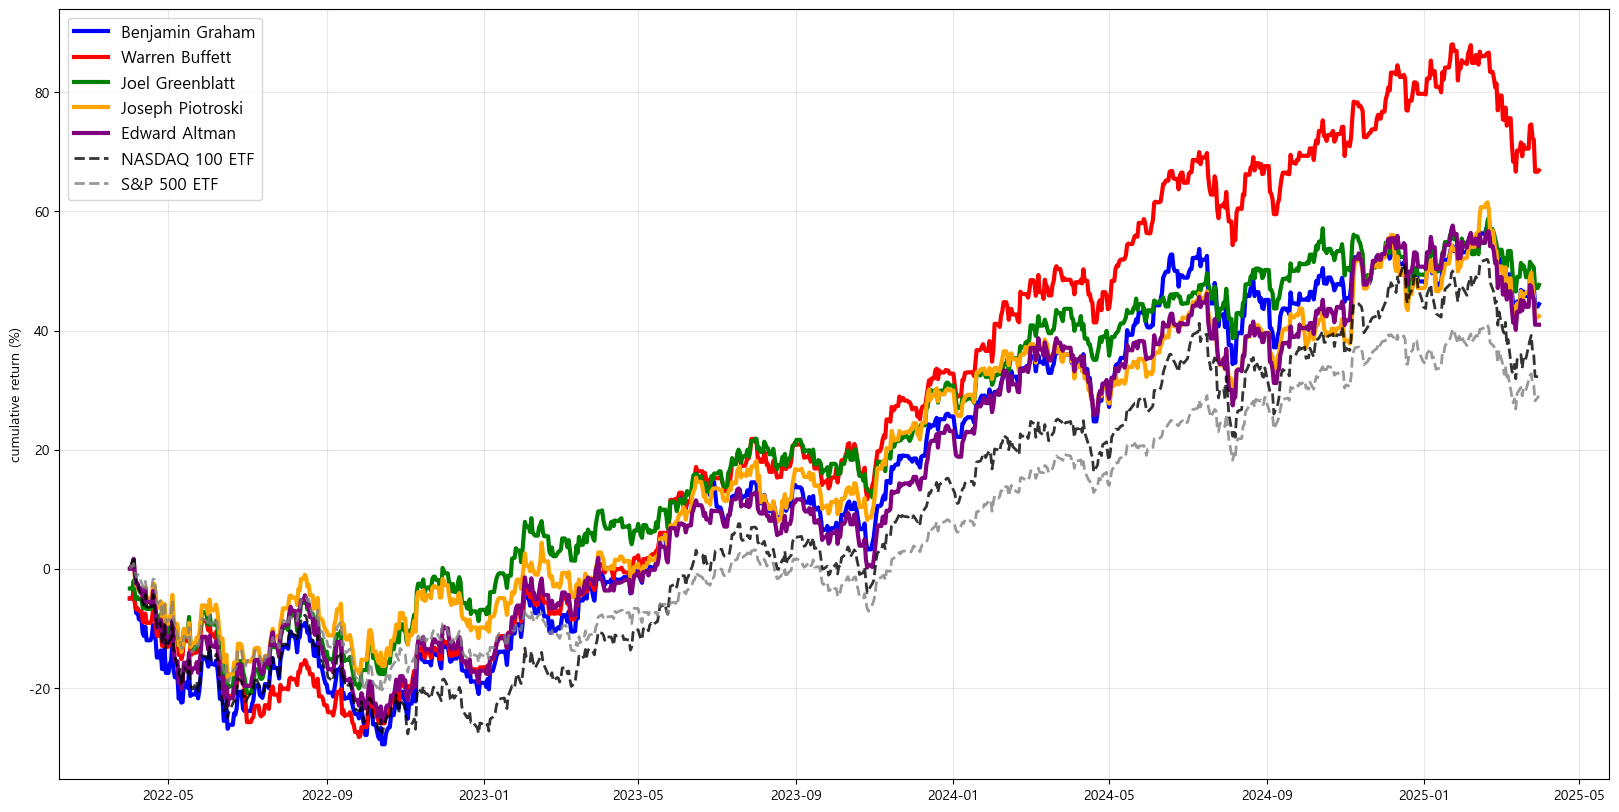

In [41]:
# 차트 그리기
backtester.plot_multi_agent_performance()


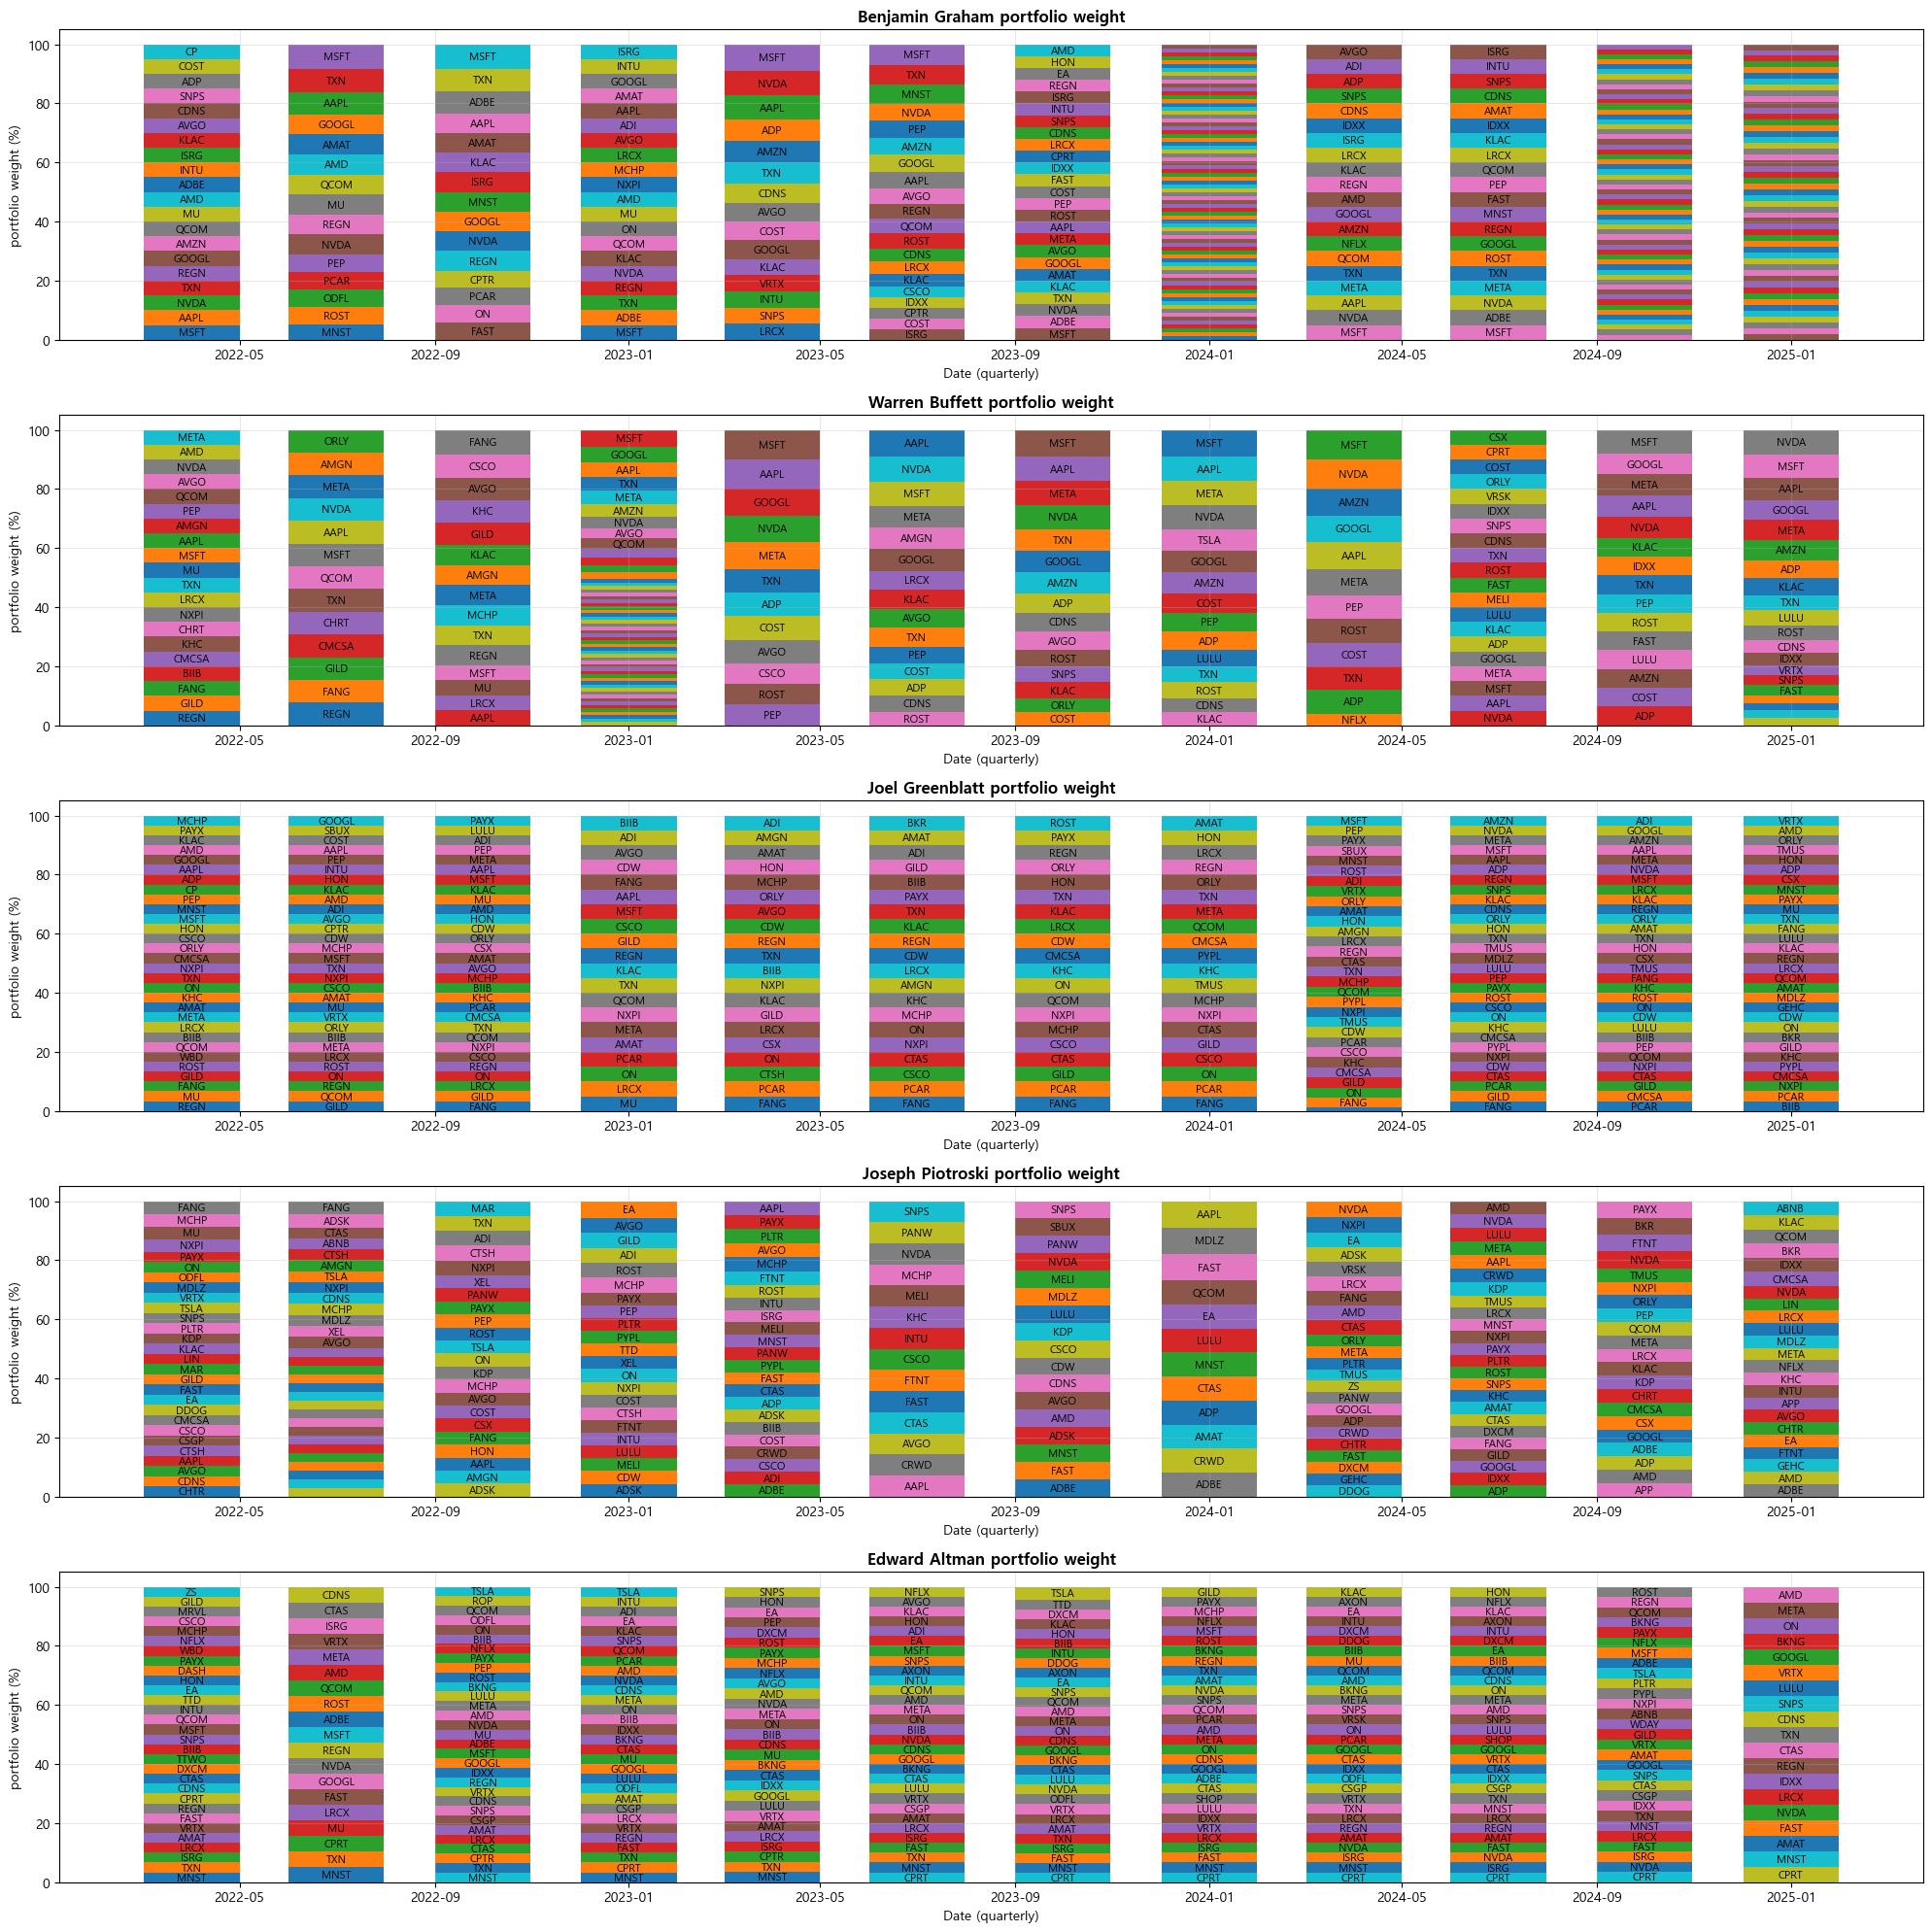

In [48]:
backtester.plot_weight_histogram()

In [30]:
# 결과 저장
backtester.save_multi_agent_results()


결과가 results\multi_agent_backtest_results.xlsx에 저장되었습니다.
